In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv
Saving train.csv to train (1).csv


In [ ]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
# train

In [ ]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
# посмотрим на соотношение классов,
# видим что у нас сбалансированная выборка
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# сделаем обработку текста
# очистим от знаков, стоп слов
import numpy as np
import nltk
import re
import string
nltk.download("stopwords")
from nltk.corpus import stopwords
from string import punctuation
russian_stopwords = stopwords.words("english")
import nltk
nltk.download('punkt')
nltk.download('punkt')

def remove_punct(text):
    # удаление пунктуации в тексте
    table = {33: ' ', 34: ' ', 35: ' ', 36: ' ', 37: ' ', 38: ' ', 39: ' ', 40: ' ', 41: ' ', 42: ' ', 43: ' ', 44: ' ', 45: ' ', 46: ' ', 47: ' ', 58: ' ', 59: ' ', 60: ' ', 61: ' ', 62: ' ', 63: ' ', 64: ' ', 91: ' ', 92: ' ', 93: ' ', 94: ' ', 95: ' ', 96: ' ', 123: ' ', 124: ' ', 125: ' ', 126: ' '}
    return text.translate(table)

def txt_prep(df):
    # функция приводит весь текст к нижнему регистру
    # удаляет пунктуацию
    # удаляет стоп слова
    df['text_init'] = df['text']
    df['text'] = df['text'].str.lower()
    df['text'] = df['text'].map(lambda x: remove_punct(x))
    df['text'] = df['text'].map(lambda x: x.split(' '))
    df['text'] = df['text'].map(lambda x: [token for token in x if token not in russian_stopwords\
                                                                    and token != " " \
                                                                    and token.strip() not in punctuation])
    df['text'] = df['text'].map(lambda x: ' '.join(x))
    df['text'] = df['text'].str.replace('»', '')
    df['text'] = df['text'].str.replace('«', '')
    return df

def delete_digits(df):
    # удалим цифры
    for index, row in df.iterrows():
        df.loc[index, 'text'] = re.sub(r"\d+", "", row['text'])
    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
re.sub(r"\d+", "", train.loc[3, 'text'])

', people receive #wildfires evacuation orders in California '

In [ ]:
train

In [ ]:
train = txt_prep(train)
train = delete_digits(train)
train

,id,keyword,location,text,target,text_init
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,forest fire near la ronge sask canada,1,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,residents asked shelter place notified officer...,1,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,people receive wildfires evacuation orders c...,1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding bridge collapse nearb...,1,Two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,aria ahrary thetawniest control wild fires cal...,1,@aria_ahrary @TheTawniest The out of control w...
7610,10871,NaN,NaN,m utc km volcano hawaii http co zdtoydebj,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,10872,NaN,NaN,police investigating e bike collided car littl...,1,Police investigating after an e-bike collided ...


In [ ]:
train['id']

0           1
1           4
2           5
3           6
4           7
        ...  
7608    10869
7609    10870
7610    10871
7611    10872
7612    10873
Name: id, Length: 7613, dtype: int64

10.353523721787194


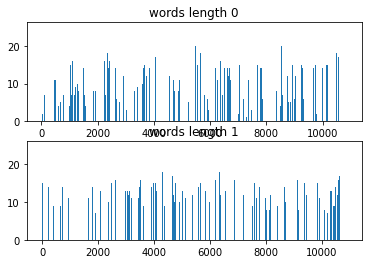

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

train['len'] = train['text'].str.split().apply(len)
print(train[train['target'] == 0]['len'].mean())
train[train['target'] == 1]['len'].mean()

fig, axes = plt.subplots(2, 1)

axes[0].bar(train[train['target'] == 0]['id'].values, train[train['target'] == 0]['len'].values)
axes[1].bar(train[train['target'] == 1]['id'].values, train[train['target'] == 1]['len'].values)

axes[0].set_title('words length 0')
axes[1].set_title('words length 1')

plt.show()

In [ ]:
print(train[train['target'] == 1]['len'].min())
print(train[train['target'] == 0]['len'].min())
print(train[train['target'] == 1]['len'].max())
print(train[train['target'] == 0]['len'].max())

2
1
25
25


In [ ]:
train

,id,keyword,location,text,target,text_init,len
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1,Our Deeds are the Reason of this #earthquake M...,7
1,4,NaN,NaN,forest fire near la ronge sask canada,1,Forest fire near La Ronge Sask. Canada,7
2,5,NaN,NaN,residents asked shelter place notified officer...,1,All residents asked to 'shelter in place' are ...,11
3,6,NaN,NaN,people receive wildfires evacuation orders c...,1,"13,000 people receive #wildfires evacuation or...",6
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1,Just got sent this photo from Ruby #Alaska as ...,9
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding bridge collapse nearb...,1,Two giant cranes holding a bridge collapse int...,11
7609,10870,NaN,NaN,aria ahrary thetawniest control wild fires cal...,1,@aria_ahrary @TheTawniest The out of control w...,12
7610,10871,NaN,NaN,m utc km volcano hawaii http co zdtoydebj,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,8
7611,10872,NaN,NaN,police investigating e bike collided car littl...,1,Police investigating after an e-bike collided ...,17


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfVectorizer преобразует тексты в числовые вектора,
# отражающие важность использования каждого слова из некоторого набора слов
# (количество слов набора определяет размерность вектора) в каждом тексте
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train.drop(['id', 'keyword','location', 'text_init','target'],axis=1),
                                                    train['target'],
                                                    test_size=0.3,
                                                    random_state=42)

# возьмем tf idf
# Parameter election
ngram_range = (1,2)
max_features = 500

tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        min_df=3,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)

x_train = tfidf.fit_transform(X_train['text']).toarray()
x_test = tfidf.transform(X_test['text']).toarray()

x_train = np.column_stack((x_train, np.array(X_train.len)))
x_test = np.column_stack((x_test, np.array(X_test.len)))

print("train:", x_train.shape)
print("test:", x_test.shape)

train: (5329, 501)
test: (2284, 501)


In [ ]:
# возьмем catboost и xgb для классификации
# !pip install catboost
from catboost import CatBoostClassifier
import sklearn

model_cb = CatBoostClassifier()
model_cb.fit(x_train, y_train)

model_cb_preds = model_cb.predict(x_test)

In [ ]:
sklearn.metrics.accuracy_score(y_test, model_cb_preds)

0.7631348511383538

In [ ]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=100)

xgb_clf.fit(x_train, y_train)

xgb_clf_preds = xgb_clf.predict(x_test)

sklearn.metrics.accuracy_score(y_test, xgb_clf_preds)

0.7486865148861647

In [ ]:
test = txt_prep(test)
x_test_final = tfidf.transform(test['text']).toarray()
y_test_pred = model_cb.predict(x_test_final)
y_test_pred = pd.DataFrame(y_test_pred, columns=['target'])

submition = pd.concat([test['id'], y_test_pred], axis=1)
submition
submition.to_csv('submition_kaggle.csv', index=False)
files.download("submition_kaggle.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
submition

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1
